In [1]:
import os
import numpy as np
import scipy.ndimage as scnd
import skimage as sk
import skimage.io as skio
from matplotlib import pyplot as plt

In [2]:
def load_grid(path='./data/'):
    assert path[-1] == '/'
    files = os.listdir(path)
    x = max(int(f[4:6]) for f in files) + 1
    y = max(int(f[7:9]) for f in files) + 1
    im_shape = skio.imread(f'{path}{files[0]}').shape
    grid = np.zeros((x, y, *im_shape))
    for x_ in range(x):
        for y_ in range(y):
            file = next(filter(lambda f: f[4:9] == f'{x_:02}_{y_:02}', files))
            grid[x_, y_] = sk.img_as_float(skio.imread(f'{path}{file}'))
    return grid
    
grid = load_grid()

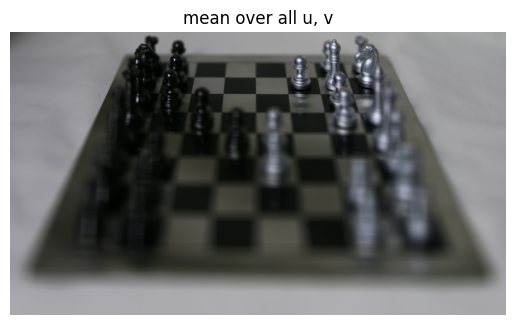

In [3]:
plt.imshow(np.mean(grid, axis=(0, 1)))
plt.title('mean over all u, v')
plt.axis('off')
plt.show()

In [22]:
def refocus(grid, c, mute=False):
    if not mute:
        print(f'refocusing with c={c}')

    w, h = grid.shape[:2]
    centroid_x, centroid_y = w // 2, h // 2
    grid_shifted = np.zeros(grid.shape)
    for x in range(w):
        for y in range(h):
            shift = (int(c * (x - centroid_x)), int(c * (centroid_y - y)))
            grid_shifted[x, y] = np.roll(grid[x, y], shift, axis=(0, 1))
            
    return np.mean(grid_shifted, axis=(0, 1))

refocusing with c=-1.0
refocusing with c=-1.0
refocusing with c=-0.9
refocusing with c=-0.8
refocusing with c=-0.7000000000000001
refocusing with c=-0.6000000000000001
refocusing with c=-0.5000000000000001
refocusing with c=-0.40000000000000013
refocusing with c=-0.30000000000000016
refocusing with c=-0.20000000000000018
refocusing with c=-0.1000000000000002
refocusing with c=-2.220446049250313e-16
refocusing with c=0.09999999999999964
refocusing with c=0.19999999999999973
refocusing with c=0.2999999999999998
refocusing with c=0.3999999999999997
refocusing with c=0.49999999999999956
refocusing with c=0.5999999999999996
refocusing with c=0.6999999999999997
refocusing with c=0.7999999999999996
refocusing with c=0.8999999999999995
refocusing with c=0.9999999999999996


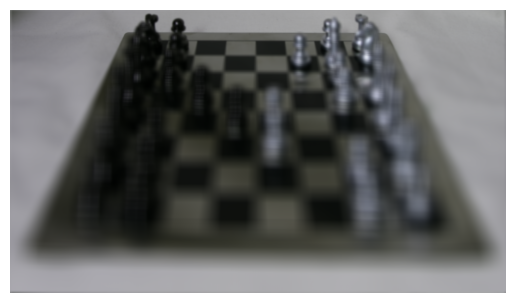

In [5]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
plt.rcParams["animation.html"] = "jshtml"
plt.axis('off')
plt.ioff()

c = np.arange(-1, 1 + 1e-3, 0.1)
w, h = grid.shape[:2]
def animate(i):
    ax.imshow(refocus(grid, c[i]))

animation.FuncAnimation(fig, animate, frames=len(c))

refocusing with c=-1
refocusing with c=0
refocusing with c=1


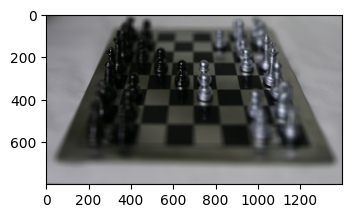

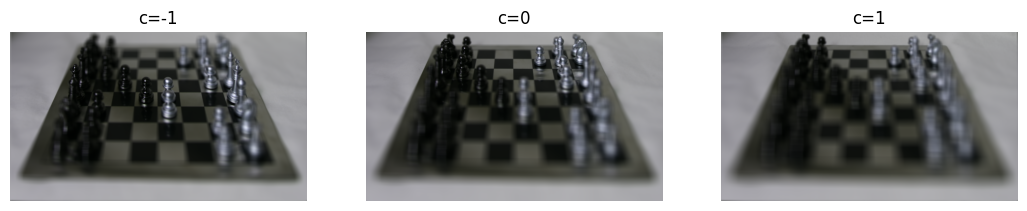

In [10]:
plt.figure(figsize=(13, 6))

for i in range(3):
    ax = i + 1
    c = i - 1
    plt.subplot(1, 3, ax)
    plt.imshow(refocus(grid, c))
    plt.axis('off')
    plt.title(f'c={c}')

plt.show()

In [45]:
def aperture(grid, r=5, c=-1, pt=None):
    if pt is None:
        pt = grid.shape[:2]
    w, h = pt
    # d = 2r, 2s^2 = d^2 -> s = sqrt(d^2/2) = sqrt(2r^2)
    # square side length
    s = int((2 * r) ** (1/2))
    if s >= w or s >= h:
        return refocus(grid, c)
    l_x, r_x = w // 2 - s // 2, int(w // 2 + (s + 0.5) // 2)
    t_y, b_y = h // 2 - s // 2, int(h // 2 + (s + 0.5) // 2)
    subgrid = grid[l_x:r_x + 1, t_y:b_y + 1]
    return refocus(subgrid, c)

refocusing with c=-1
refocusing with c=-1
refocusing with c=-1


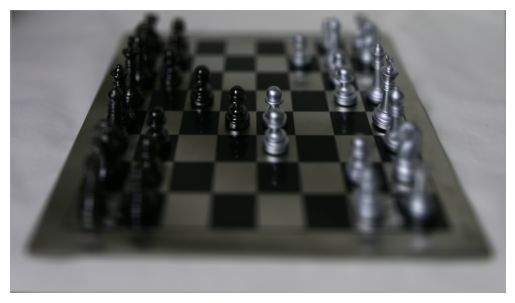

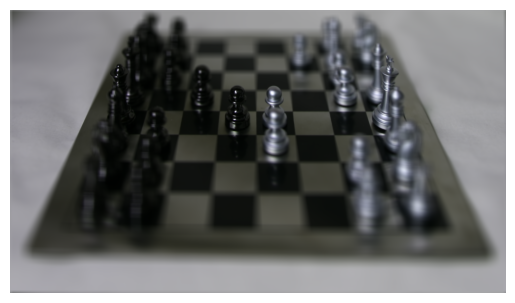

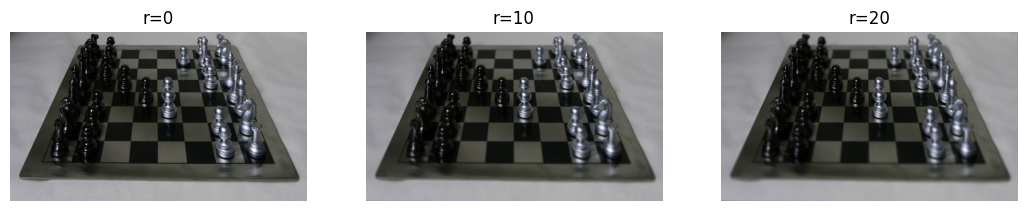

In [46]:
plt.figure(figsize=(13, 6))

for i in range(3):
    ax = i + 1
    r = i * 10
    plt.subplot(1, 3, ax)
    plt.imshow(aperture(grid, r))
    plt.axis('off')
    plt.title(f'r={r}')

plt.show()

In [44]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
plt.rcParams["animation.html"] = "jshtml"
plt.axis('off')
plt.ioff()

r = np.arange(0, 20, 2)
def animate(i):
    ax.imshow(aperture(grid, r[i]))

animation.FuncAnimation(fig, animate, frames=len(r))

refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1
refocusing with c=-1


In [117]:
def interactive_refocus(grid, x, y, delta1=40, delta2=40, step_size=0.2):
    im = grid[8,8]
    w, h = im.shape[:2]
    s = int((2 * delta1) ** (1/2))
    l_x, r_x = x - s // 2, int(x + (s + 0.5) // 2)
    t_y, b_y = y - s // 2, int(y+ (s + 0.5) // 2)
    patch = np.ravel(im[l_x:r_x+1,t_y:b_y+1])
    def ncc(b):
        return patch.dot(np.ravel(b[delta2:-delta2, delta2:-delta2]))
    # consider c in -1, 1
    search_space = np.arange(-1, 1+1e-5, step_size)
    # we only care about the area around patch, so
    # messy code to garuantee at least some padding
    grid = grid[..., l_x-delta2:r_x+1+delta2,t_y-delta2:b_y+1+delta2, :]
    return [(c, ncc(refocus(grid, c, mute=True))) for c in search_space]

In [118]:
coords = [(200, 1000), (200, 200), (400, 700), (700, 200)]
results = [(coord, interactive_refocus(grid, coord[0], coord[1])) for coord in coords]
results = [(coord, r1, refocus(grid, max(r1, key=lambda c: c[1])[0])) for coord, r1 in results]
print(results)

refocusing with c=0.19999999999999973
refocusing with c=-2.220446049250313e-16
refocusing with c=-1.0
refocusing with c=-1.0
[((200, 1000), [(np.float64(-1.0), np.float64(79.47901209143673)), (np.float64(-0.8), np.float64(83.62235190351325)), (np.float64(-0.6000000000000001), np.float64(86.11987936500333)), (np.float64(-0.40000000000000013), np.float64(87.8865497832215)), (np.float64(-0.20000000000000018), np.float64(89.03979762907262)), (np.float64(-2.220446049250313e-16), np.float64(89.4317010891472)), (np.float64(0.19999999999999973), np.float64(89.48933715938368)), (np.float64(0.3999999999999997), np.float64(89.17609543308467)), (np.float64(0.5999999999999996), np.float64(88.30619035265912)), (np.float64(0.7999999999999996), np.float64(86.6951386544169)), (np.float64(0.9999999999999996), np.float64(85.32818365041922))], array([[[0.37347174, 0.3781532 , 0.36614424],
        [0.32821765, 0.33333333, 0.31820341],
        [0.33080942, 0.33614221, 0.32118868],
        ...,
        [0.62

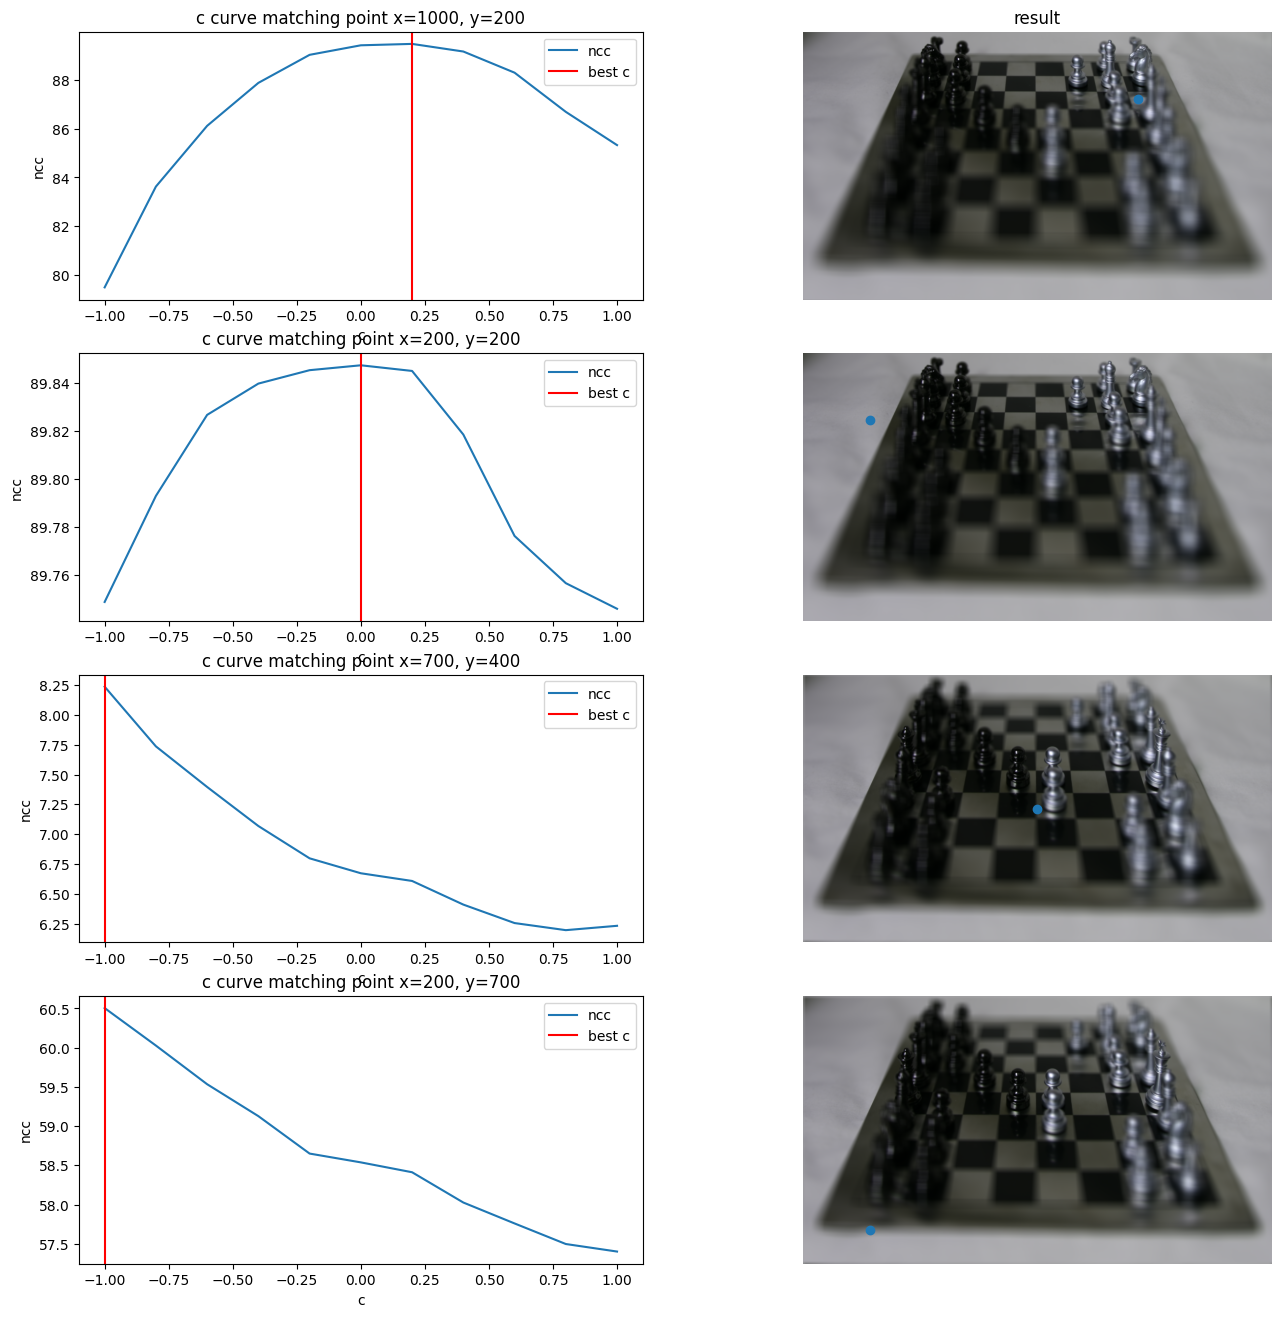

In [130]:
fig, rows = plt.subplots(4, 2, figsize=(16, 16))

for (row, ((x, y), c, im)) in zip(rows, results):
    row[0].plot([c[0] for c in c], [c[1] for c in c], label='ncc')
    row[0].set_xlabel('c')
    row[0].set_ylabel('ncc')
    row[0].axvline(max(c, key=lambda c: c[1])[0], label='best c', color='red')
    # uuuh... i swapped x and y before, so...
    row[0].set_title(f'c curve matching point x={y}, y={x}')
    row[0].legend()

    row[1].imshow(im)
    row[1].plot(y, x, 'o')
    row[1].axis('off')

rows[0][1].set_title('result')

plt.show()